## Modeling modules

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.utils.validation import check_array
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xg
from math import sqrt

from xgboost import plot_importance

In [20]:
def read_Data(sales_path, item_cat_path, item_path, shop_path, test_path):
  """
    Function to read all the dataset and merge them to one
    1. Sales Data
    2. Item_category Data
    3. Shop data
    4. Item_category_df
  """
  sales_df = pd.read_csv(sales_path)
  item_cat_df = pd.read_csv(item_cat_path)
  items_df = pd.read_csv(item_path)
  shops_df = pd.read_csv(shop_path)
  test_df = pd.read_csv(test_path)

  final_df = pd.merge(sales_df,items_df,how='left',on='item_id') # sales df + item_df
  final_df = pd.merge(final_df, item_cat_df, how='left', on='item_category_id') # sales df + item_df + item_cat_df
  final_df = pd.merge(final_df, shops_df, how='left', on = 'shop_id') # sales df + item_df + item_cat_df + shop_df
  return final_df, test_df


In [42]:
def fix_DataType(sales_df):
  # converting datetime column to correct format
  sales_df['date'] = pd.to_datetime(sales_df['date'],format='%d.%m.%Y')
  # print(sales_df.info())
  return sales_df

In [62]:
def cap_Outlier(lvled_data):
  """
    Function to cap outliers with 99th percentile (upper) and 0 (-ve values)
  """

  lvled_data.loc[lvled_data['item_price'] < 0,'item_price'] = 0.01
  percentiles = lvled_data['item_price'].quantile([0.99]).values
  lvled_data.loc[lvled_data['item_price'] >= percentiles[0],'item_price'] = percentiles[0]

  lvled_data.loc[lvled_data['item_cnt_day'] < 0,'item_price'] = 0.01
  percentiles_cnt = lvled_data['item_cnt_day'].quantile([0.99]).values
  lvled_data.loc[lvled_data['item_cnt_day'] >= percentiles_cnt[0],'item_cnt_day'] = percentiles_cnt[0]

  return lvled_data

In [23]:
def drop_Outlier(lvled_data):
  """
    Function to cap outliers with 99th percentile (upper) and 0 (-ve values)
  """
  percentiles_price = lvled_data['item_price'].quantile([0.99]).values
  percentiles_cnt = lvled_data['item_cnt_day'].quantile([0.99]).values

  lvled_data = lvled_data[lvled_data['item_price'] <= percentiles_price[0]]
  lvled_data = lvled_data[lvled_data['item_price'] >= 0]

  lvled_data = lvled_data[lvled_data['item_cnt_day'] <= percentiles_cnt[0]]
  lvled_data = lvled_data[lvled_data['item_cnt_day'] >= 0]

  return lvled_data


In [24]:
def create_Features(final_df):
  """
    Function to create features:
      1. Date featues 
      2. Proportion Features
      3. Shop Clusters (Item clusters are already present as item_category_id)
  """

  ## 1. creating date features
  final_df['week'] = final_df['date'].dt.week
  final_df['weekday'] = final_df['date'].dt.weekday
  final_df['month'] = final_df['date'].dt.month
  final_df['year'] = final_df['date'].dt.year


  ## 2. sales(count and revenue) proportion of each item sold compared to whole sales volume on that shop
  # creating the day-level item_count, item_price sum dataframe
  day_levl_sum_df = final_df.groupby(['date', 'shop_id']).agg({'item_cnt_day':'sum', 'item_price':'sum'}).rename(columns={'item_cnt_day':'item_cnt_day_sum', 'item_price':'item_price_sum'}).reset_index()
  
  final_df_prop = pd.merge(final_df, day_levl_sum_df, how='inner', left_on=['date', 'shop_id'], right_on=['date', 'shop_id']) ## Merging day-level with final_df

  final_df_prop['price_prop'] = (final_df_prop['item_price'] / final_df_prop['item_price_sum'])*100 # creating the proportion columns out of price



  ## 3. clustering of shops based on count of unique items in the shop and total sales
  shop_item_df = final_df_prop.groupby(['shop_id','item_id'], as_index=False).agg({'item_cnt_day':'sum', 'item_price':'sum'}).rename(columns={'item_cnt_day':'item_cnt_day_sum', 'item_price':'item_price_sum'})
  
  # grouping based on shops: getting unique item_ids, total sum of count sales, total revenue 
  shop_grp_df = shop_item_df.groupby(['shop_id'], as_index=False).agg({'item_id':pd.Series.nunique, 'item_cnt_day_sum':'sum', 'item_price_sum': 'sum'})
 
  # kmeans for clustering
  range_n_clusters = range(2,50)
  dataToFit = shop_grp_df[['item_id', 'item_cnt_day_sum', 'item_price_sum']]
  best_clusters = 0                      
  previous_silh_avg = 0.0

  for n_clusters in range_n_clusters:
      clusterer = KMeans(n_clusters=n_clusters)
      cluster_labels = clusterer.fit_predict(dataToFit)
      silhouette_avg = silhouette_score(dataToFit, cluster_labels)

      if silhouette_avg > previous_silh_avg:
          previous_silh_avg = silhouette_avg
          best_clusters = n_clusters

  # Final Kmeans for best_clusters
  kmeans = KMeans(n_clusters=best_clusters, random_state=0).fit(dataToFit)
  shop_grp_df['shop_clusters'] = kmeans.predict(dataToFit).tolist()
  shop_grp_df.drop(['item_id', 'item_cnt_day_sum', 'item_price_sum'], axis=1, inplace=True)

  df_date_prop_clust = pd.merge(final_df_prop, shop_grp_df, how='inner', left_on=['shop_id'], right_on=['shop_id']) ## Merging day-level with final_df

  ## selecting only required features: dropping ['date', 'item_name', 'item_category_name', 'shop_name', 'week', 'weekday', 'item_cnt_day_sum', 'item_price_sum']
  df = df_date_prop_clust[['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_category_id', 'month', 'year', 'price_prop', 'shop_clusters']]
  
  return df



In [25]:
def grouped_Data(final_df):
  """
     grouping data and selecting sum, mean and first values
  """
  df_grp = final_df.groupby(
      ["date_block_num", "shop_id", "item_id"]).agg({"item_price": "sum","item_cnt_day": "sum", 'item_category_id':'first', 'month':'first', \
                                                     'year':'first', 'price_prop':'mean', 'shop_clusters':'first'}).reset_index()

  df_grp = df_grp.sort_values(by=['date_block_num'], ascending=True).reset_index(drop=True)
  return df_grp

In [26]:
def prepare_Dependent_Independent_vars(data):
  """
    To prepare the dependent and independant variables
  """
  data2 = data.drop('date_block_num', axis=1)
  x=data2.drop('item_cnt_day',axis=1)
  y=data2[['item_cnt_day']]

  return x, y

In [27]:
def prepare_Train_Test_split(df, use_cols, thresh):
  """
    Function to build train-test split
  """
  model_data1 = df[use_cols]
  train_data = model_data1[model_data1['date_block_num'] <= thresh]
  print(train_data.shape)
  test_data = model_data1[model_data1['date_block_num'] > thresh]
  print(test_data.shape)

  # fixing train data
  x_train, y_train = prepare_Dependent_Independent_vars(train_data)

  # Fixing test data
  x_test, y_test = prepare_Dependent_Independent_vars(test_data)


  return x_train, y_train, x_test, y_test


In [28]:
def LR_Model(x_train, y_train, x_test, y_test):
  """
    Function to test the prediction from Linear Regression
  """
  print('Linear Reg')
  lin_reg = LinearRegression().fit(x_train, y_train)
  y_predict = lin_reg.predict(x_test)

  rms = sqrt(mean_squared_error(y_test, y_predict))
  print("RMSE for Linear regressor is: ",rms)

  r2_scoree = r2_score(y_test, y_predict)
  print("R2 square for Linear regressor is: ",r2_scoree)

In [29]:
def LR_Model_OLS(x_train, y_train, x_test, y_test):
  x_train = sm.add_constant(x_train, has_constant='add')
  lin_reg = sm.OLS(y_train, x_train)
  model = lin_reg.fit()
  model.summary()

In [30]:
def XGB_Model(x_train, y_train, x_test, y_test):
  """
    Function to test the prediction from XGB
  """
  print("XGBoost")
  xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123).fit(x_train, y_train)
  y_predict = xgb_r.predict(x_test)

  rms = sqrt(mean_squared_error(y_test, y_predict))
  print("RMSE for XGB regressor is: ",rms)
  r2_scoree = r2_score(y_test, y_predict)
  print("R2 for XGB regressor square is: ",r2_scoree)

  return xgb_r

In [31]:
def final_model_prep(data, use_cols, test_df):
  """
    Function to create the final model
  """

  model_data1 = data[use_cols]
  x, y = prepare_Dependent_Independent_vars(model_data1)
  model = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123).fit(x, y)
  return model


In [32]:
def kaggle_Submission(model_data1, use_cols, test_df):
  """
    Modeling building and Submission csv preparation
  """
  print("Kaggle Submission")
  final_model  = final_model_prep(model_data1, use_cols, test_df)
  
  # creating unique column for grouping
  test_df['lvl'] = test_df['shop_id'].astype(str) + '_' + test_df['item_id'].astype(str)
  model_data1['lvl'] = model_data1['shop_id'].astype(str) + '_' + model_data1['item_id'].astype(str)

  # grouping data before adding features to Test Data
  # We have to group, as same shop_id, item_id is coming in every month
  map_data = model_data1.groupby(['lvl']).agg(
      item_price  = ('item_price', np.mean),
      price_prop  = ('price_prop', np.mean),
      shop_clusters  = ('shop_clusters', pd.Series.mode)
  ).reset_index()

  # merging with test data
  updated_test_data = pd.merge(test_df, map_data,  how='left', on=['lvl'])

  # preparing test data with train features
  updated_test_data_new = updated_test_data[['shop_id', 'item_id','item_price', \
        'price_prop', 'shop_clusters']]

  # predicting on test data
  y_kaggle_pred = final_model.predict(updated_test_data_new)

  # submission file
  submit = pd.DataFrame(columns = ('ID', 'item_cnt_month'))
  submit['item_cnt_month'] = y_kaggle_pred
  submit['ID'] = updated_test_data['ID']
  submit.to_csv("submit.csv", index=False)

In [33]:
def modeling_function(data, thresh_train):
  ## Modeling- cap data 
  use_cols = ['date_block_num', 'shop_id', 'item_id', 'item_price', 'price_prop', 'shop_clusters', 'item_cnt_day']

  # train_thresh = 80
  x_train, y_train, x_test, y_test = prepare_Train_Test_split(data, use_cols, thresh_train)

  # trying LR model
  LR_Model(x_train, y_train, x_test, y_test)

  # trying XGB Model
  # xgb_model = xgb_r
  xgb_model = XGB_Model(x_train, y_train, x_test, y_test)

  # Kaggle Submission CSV
  kaggle_Submission(data, use_cols, test_df)

  return xgb_model

In [58]:
## Reading whole data

sales_path = '/content/drive/MyDrive/Projects/competitive-data-science-predict-future-sales/sales_train.csv'
item_cat_path = '/content/drive/MyDrive/Projects/competitive-data-science-predict-future-sales/item_categories.csv'
item_path = '/content/drive/MyDrive/Projects/competitive-data-science-predict-future-sales/items.csv'
shop_path = '/content/drive/MyDrive/Projects/competitive-data-science-predict-future-sales/shops.csv'
test_path = '/content/drive/MyDrive/Projects/competitive-data-science-predict-future-sales/test.csv'

# reading the data
data, test_df = read_Data(sales_path, item_cat_path, item_path, shop_path, test_path)
data_fix = fix_DataType(data) # for fixing data types
data_fix.head()

# setting threshhold for train-test split
thresh_train = int((data_fix.date_block_num.nunique()) * 0.8)

In [63]:
# # preparing dataset after capping item_count, item_price outliers
cap_outlier_data = cap_Outlier(data_fix)
cap_outlier_data_feat = create_Features(cap_outlier_data)
cap_outlier_grp_data = grouped_Data(cap_outlier_data_feat)
cap_outlier_data_xgb_model = modeling_function(cap_outlier_grp_data, thresh_train)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


(1416773, 7)
(192351, 7)
Linear Reg
RMSE for Linear regressor is:  3.324037517966325
R2 square for Linear regressor is:  0.21902815766802608
XGBoost
[16:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for XGB regressor is:  2.7373844604775046
R2 for XGB regressor square is:  0.4703668780789211
Kaggle Submission
[16:22:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
(1416773, 7)
(192351, 7)
Linear Reg
RMSE for Linear regressor is:  3.324037517966325
R2 square for Linear regressor is:  0.21902815766802608
XGBoost
[16:23:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for XGB regressor is:  2.7373844604775046
R2 for XGB regressor square is:  0.4703668780789211
Kaggle Submission
[16:24:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now d

In [65]:
# preparing dataset after dropping item_count, item_price outliers
drop_outlier_data = drop_Outlier(data_fix)
drop_outlier_data_feat = create_Features(drop_outlier_data)
drop_outlier_grp_data = grouped_Data(drop_outlier_data_feat)
thresh_train = int((drop_outlier_grp_data.date_block_num.nunique()) * 0.8)
print("drop outlier")
# modeling_function(drop_outlier_grp_data, thresh_train)
drop_outlier_data_xgb_model = modeling_function(drop_outlier_grp_data, thresh_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


drop outlier
(1415965, 7)
(192261, 7)
Linear Reg
RMSE for Linear regressor is:  3.3230647060759524
R2 square for Linear regressor is:  0.21991689235562062
XGBoost
[16:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for XGB regressor is:  2.6912013687033287
R2 for XGB regressor square is:  0.48837039357349454
Kaggle Submission
[16:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#### Feature Importance for Drop outlier Model

In [70]:
## Importance from drop outlier model
print("drop outlier feat \n",drop_outlier_data_xgb_model.get_booster().get_score(importance_type='total_cover'))

drop outlier feat 
 {'item_price': 28261284.0, 'price_prop': 14200664.0, 'item_id': 17002.0}


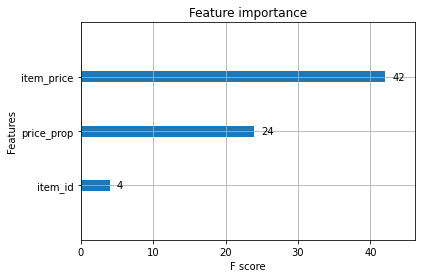

In [71]:
plot_importance(drop_outlier_data_xgb_model, )

#### Feature Importance for Cap outlier Model

In [72]:
## Importance from drop outlier model
print("drop outlier feat \n",cap_outlier_data_xgb_model.get_booster().get_score(importance_type='total_cover'))

drop outlier feat 
 {'item_price': 28287628.0, 'price_prop': 14199936.0, 'item_id': 15626.0}


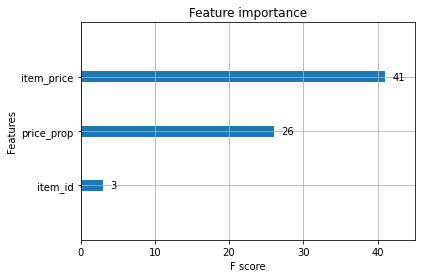

In [73]:
plot_importance(cap_outlier_data_xgb_model, )

## Insights generation

**Observations out of EDA**:


*   The correlation between prices and items_cnt shows that on prices increases on increase in items_cnt sale, for each and every shop. No discount on bulk purchases.
*   Similar correlation observed when checked across months for all shops among prices and items_cnt i.e., item_cnt_sales the item_prices increases or vice-versa.
*   Outlier Analysis on 'item_cnt_day' shows outliers both negative and beyond 500 (just 12 records out of 29 Lkhs records), whereas the 99th percentile value is just 5
*   Outlier Analysis on 'item_price' shows outliers both negative and beyond 600 (just 240 records out of 29Lks records) which the also the 99th percentile value
*   We observed that Saturday, Sunday have higher sales price, as well as highest item_cnt_day
*   We observed that almost every year, january and dec months get the highest sales_price and item_cnt_day


**Feature Creation: (Based on EDA observations)**


*   Created features out of the date column to as we have observed correlation among month and item sales
*   created features out of price as their proportion sales (revenue of an item in that shop on that day / total revenue of shop on that day)

**Final Dataset: (Based on EDA Observations)**
  - Created two different datasets for Model building and validation
    > 1. dropped the outliers based on item_cnt_day, item_price column
    > 2. capped the outliers based on item_cnt_day, item_price column

  - train-validation Dataset:
    > We have selected initial 80% of months (first 27 months) for training and remaining 20% for validation

  - Used Linear Regression and XGBoost Regressor for final prediction. 
    > Linear Regression was not able to predict neither train data nor test data (high bias)
    > To overcome, we used XGB, which is a boosting ensemble technique, thus handling the bias problem.

  - Final prediction shows below results:
    > XGB outperformed LR 
    > dropped outlier dataset gave better results then capped outliers
    > Final model (XGB on dropped dataset) gave below results:
      RMSE for XGB regressor is:  2.6912013687033287
      R2 for XGB regressor square is:  0.48837039357349454

  - Kaggle Submission:
    > For kaggle submission we prepared the test dataset, and created the features from train dataset (based on shop_id, item_id)
    > used drop-outlier module on whole train data (33 months) and XGB for training.
    > Our final Kaggle public score is: 3.98630 (the less the better)